In [62]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import sys

from importlib import reload # 自訂 function 可重新 reload
sys.path.append('/home/hchuang/Documents/Project/SSSD_CP/src/datasets_script/NYISO')
from utils.data_utils import *
sys.path.append('/home/hchuang/Documents/Project/SSSD_CP/src')
from utils import util_inference_result
reload(util_inference_result)
from utils.util_inference_result import *





# Read data

In [79]:
main_folder_path = "/home/hchuang/Documents/Project/SSSD_CP/src/"
DATASET = 'dataset_4' # dataset_4 or dataset 6
result = load_result_data(main_folder_path, DATASET)


# true_data_I2_all_o = result['true_data_I2_all_o']
# true_data_I2_cond_o = result['true_data_I2_cond_o']
# true_data_I2_target_o = result['true_data_I2_target_o']
# true_data_I2_all = result['true_data_I2_all']
# true_data_I2_cond = result['true_data_I2_cond']
# true_data_I2_target = result['true_data_I2_target']
# mul_pred_data_I2 = result['mul_pred_data_I2']
# median_pred_data_I2 = result['median_pred_data_I2']
# mul_pred_data_I2_o = result['mul_pred_data_I2_o']
# median_pred_data_I2_o = result['median_pred_data_I2_o']

# true_data_test_all_o = result['true_data_test_all_o']
# true_data_test_cond_o = result['true_data_test_cond_o']
# true_data_test_target_o = result['true_data_test_target_o']
# true_data_test_all = result['true_data_test_all']
# true_data_test_cond = result['true_data_test_cond']
# true_data_test_target = result['true_data_test_target']
# mul_pred_data_test = result['mul_pred_data_test']
# median_pred_data_test = result['median_pred_data_test']
# mul_pred_data_test_o = result['mul_pred_data_test_o']
# median_pred_data_test_o = result['median_pred_data_test_o']

true_data_I2_all = result['true_data_I2_all_o']
true_data_I2_cond = result['true_data_I2_cond_o']
true_data_I2_target = result['true_data_I2_target_o']
mul_pred_data_I2 = result['mul_pred_data_I2_o']
median_pred_data_I2 = result['median_pred_data_I2_o']

true_data_test_all = result['true_data_test_all_o']
true_data_test_cond = result['true_data_test_cond_o']
true_data_test_target = result['true_data_test_target_o']
mul_pred_data_test = result['mul_pred_data_test_o']
median_pred_data_test = result['median_pred_data_test_o']

true_data_I2_all, shape: (2061, 192)
true_data_I2_cond, shape: (2061, 168)
true_data_I2_target, shape: (2061, 24)
mul_pred_data_I2, shape: (50, 2061, 24)
median_pred_data_I2, shape: (2061, 24)
true_data_test_all, shape: (73, 192)
true_data_test_cond, shape: (73, 168)
true_data_test_target, shape: (73, 24)
mul_pred_data_test, shape: (50, 73, 24)
median_pred_data_test, shape: (73, 24)


## select 10/20-12/31 as calibration set

In [64]:
_,train_days_I2 = date_index(zone_number = 1)
# I2_winter_index = train_days_I2>0 # all I2
# I2_winter_index = train_days_I2>=294 # >= 10/20

I2_winter_index = train_days_I2>=287 # >= 10/20

# CPI

## Select calibration data

In [80]:
mul_pred_I2 = mul_pred_data_I2[:,I2_winter_index,:]
true_I2 = true_data_I2_target[I2_winter_index,:]
median_pred_I2 = median_pred_data_I2[I2_winter_index,:]


## 1: CPI_B

In [89]:
# conformity score
L, U = pred_interval(mul_pred_data_I2, beta = 0.05)
E_star = compute_E_star(L, U, true_data_I2_target, alpha = 0.05)

# test data
L, U = pred_interval(mul_pred_data_test, beta = 0.05)
L_star_B, U_star_B = adjust_PI(L, U, E_star)

In [121]:
# # coverage rate
# CR_barchart_compare(coverage_rate(L, U, true_data_test_target), 
#                     coverage_rate(L_star_B, U_star_B, true_data_test_target), 
#                     figure_title = "Comparing 95% PI Coverage Rate",
#                     label_1 = 'SSSD', label_2 = 'Calibration_both',
#                     color_1 = 'tab:orange', color_2 = 'tab:purple')

## 2: CPI_E

In [92]:
L, U = pred_interval(mul_pred_I2, beta = 0.05)

# conformity score
E_star_L, E_star_U = compute_E_star_separate(L, U, true_I2, alpha = 0.025)

# test data
L, U = pred_interval(mul_pred_data_test, beta = 0.05)
L_star_E, U_star_E = adjust_PI_separate(L, U, E_star_L, E_star_U)


## 3: SCP
Split conformal prediction

In [110]:
# conformity score
E_star_exd = compute_E_star_SCP(pred = median_pred_I2, true = true_I2, alpha = 0.05)

# test data
L, U = pred_interval(mul_pred_data_test, beta = 0.05)
L_star_S = median_pred_data_test - E_star_exd
U_star_S = median_pred_data_test + E_star_exd

In [75]:
# CR_barchart_compare(coverage_rate(L, U, true_data_test_target), coverage_rate(L_star, U_star, true_data_test_target), 
#                     figure_title = "Comparing 95% PI Coverage Rate",
#                     label_1 = 'SSSD', label_2 = 'Conformal Prediction',
#                     color_1 = 'tab:orange', color_2 = 'tab:green')

## 4: Bias correction

In [131]:
# 設定亂數種子（可選）
np.random.seed(0)

# 取得隨機分組索引
idx = np.random.permutation(mul_pred_data_I2.shape[1])
half = len(idx) // 2

# 切分
mul_pred_data_I2_1, mul_pred_data_I2_2 = mul_pred_data_I2[:, idx[:half], :], mul_pred_data_I2[:, idx[half:], :]

true_data_I2_target_1, true_data_I2_target_2 = true_data_I2_target[idx[:half], :], true_data_I2_target[idx[half:], :]


In [ ]:
# Bias
bias = np.mean(true_data_I2_target_1 - np.mean(mul_pred_data_I2_1,axis=0),axis=0)

mul_pred_data_I2_2_BC = mul_pred_data_I2_2 + np.expand_dims(bias, axis=0) 
mul_pred_data_test_BC = mul_pred_data_test + np.expand_dims(bias, axis=0) 

In [ ]:
# Scores and Quantile:
mean_pred_data_I2_2_BC = np.mean(mul_pred_data_I2_2_BC,axis = 0)
std_pred_data_I2_2_BC = np.std(mul_pred_data_I2_2_BC,axis = 0)

scores = np.abs(mean_pred_data_I2_2_BC-true_data_I2_target_2)/std_pred_data_I2_2_BC

# Comparison

## Coverage rate

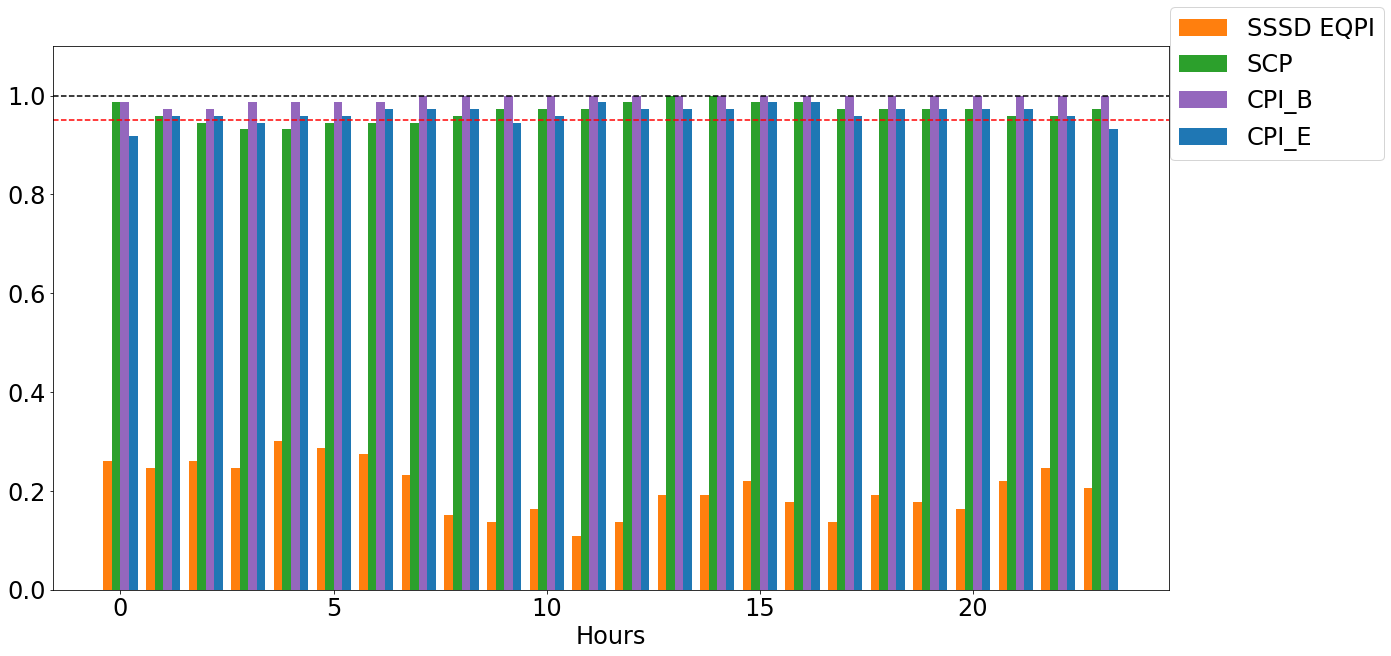

In [113]:
test_CR_original = coverage_rate(L, U, true_data_test_target)
adjusted_values1 = coverage_rate(L_star_B, U_star_B, true_data_test_target)
adjusted_values2 = coverage_rate(L_star_E, U_star_E, true_data_test_target)
adjusted_values3 = coverage_rate(L_star_S, U_star_S, true_data_test_target)
figure_title = "Comparing 95% PI Coverage Rate"
label_1 = 'CPI_B'
label_2 = 'CPI_E'
label_3 = 'SCP'
color_1 = 'tab:purple'
color_2 = 'tab:blue'
color_3 = 'tab:green'

X_axis = np.arange(len(adjusted_values1)) 


plt.figure(figsize=(20, 10)) 
plt.rcParams['font.size'] = 24 # 設置繪圖時的字體大小

plt.bar(X_axis - 0.3, test_CR_original, 0.2, label = 'SSSD EQPI', color = 'tab:orange') 
plt.bar(X_axis - 0.1, adjusted_values3, 0.2, label = label_3, color = color_3) 
plt.bar(X_axis + 0.1, adjusted_values1, 0.2, label = label_1, color = color_1) 
plt.bar(X_axis + 0.3, adjusted_values2, 0.2, label = label_2, color = color_2) 

plt.axhline(y=0.95, color='r', linestyle='--')
plt.axhline(y=1, color='black', linestyle='--')


plt.ylim(0, 1.1)
plt.xlabel("Hours") 
plt.ylabel("") 
# plt.title(figure_title) 
# plt.legend(loc = 'upper right', bbox_to_anchor=(1, 0.5)) 
plt.legend(loc=(1.001, 0.79))
plt.show() 

## MAPE

In [115]:
pred_test_cal_B = (L_star_B+U_star_B)/2
pred_test_cal_E = (L_star_E+U_star_E)/2
pred_test_cal_S = (L_star_S+U_star_S)/2

In [117]:
print(f'MAPE SSSD: {round(np.mean(abs((true_data_test_target - median_pred_data_test))/true_data_test_target)*100,4)}')
print(f'MAPE CPI_B: {round(np.mean(abs((true_data_test_target - pred_test_cal_B))/true_data_test_target)*100,4)}')
print(f'MAPE CPI_E: {round(np.mean(abs((true_data_test_target - pred_test_cal_E))/true_data_test_target)*100,4)}')
print(f'MAPE SCP: {round(np.mean(abs((true_data_test_target - pred_test_cal_S))/true_data_test_target)*100,4)}')

MAPE SSSD: 1.6407
MAPE CPI_B: 1.643
MAPE CPI_E: 1.6353
MAPE SCP: 1.6407


## Interval score

In [120]:
print(f'IS SSSD: {np.round(np.mean(Interval_Score(L,U,true,0.05)),2)}')
print(f'IS CPI_B: {np.round(np.mean(Interval_Score(L_star_B,U_star_B,true,0.05)),2)}')
print(f'IS CPI_E: {np.round(np.mean(Interval_Score(L_star_E,U_star_E,true,0.05)),2)}')
print(f'IS SCP: {np.round(np.mean(Interval_Score(L_star_S,U_star_S,true,0.05)),2)}')

IS SSSD: 219585.03
IS CPI_B: 200549.27
IS CPI_E: 211038.68
IS SCP: 209207.28


## PI

In [ ]:
# one_obs = 72 # 0, 13, 30, 72
# prediction_linechart(one_obs, true_data_test_all, median_pred_data_test)
# PI_linechart(one_obs, true_data_test_all, L, U, figure_title = "", PI_label = "SSSD", PI_color = 'tab:blue')
# PI_linechart(one_obs, true_data_test_all, L_star, U_star, figure_title = "", PI_label = "Calibration", PI_color = 'tab:red')


## Predictions

In [ ]:
# for obs in range(1):

#     data1 = median_pred_data_test[obs,:].flatten()
#     data2 = median_pred_data_calibrated[obs,:].flatten()
#     data3 = true_data_test_target[obs,:].flatten()
#     x = np.arange(1, 25)

#     plt.figure(figsize=(10, 6))
#     plt.plot(x, data1, label='SSSD', marker='o')
#     plt.plot(x, data2, label='CPI', marker='s')
#     plt.plot(x, data3, label='True', marker='^')
#     plt.legend()